# Rising Covid-19 Outbreak and Unemployment in IL
### Fall 2020 - IS 455 Data Visualization
#### Author: Jeremy Carnahan

As we enter into what many consider the "3rd wave" of COVID-19 outbreaks, we have heard about direct effects on the Illinois economy with a drastic rise in layoffs.  **This Jupyter Notebook will compile three datasets to help visualize the rise in confirmed cases across the state by time, while also showing a county-by-county impact in unemployment rates.**  

The first dataset is a monthly .csv from the United States Bureau of Labor Statistics (BLS) which is made open source to the public as it originates from the United States government, making it within the public domain.  The data is attached to this project and called:  la.data.20.Illinois.txt.  It is tab delimited, and as we'll see later in the notebook, it was a very challenging dataset to both acquire and parse as there is a lot of research required in order to understand and extract data from the coding schemes used by BLS.  We'll primarily be filtering down the data to just IL unemployment rates, for all counties, in the year 2020.  County Federal Information Processing Standard (FIPS) codes will be parsed from the statistics to pair up with geographical country boundaries data described later.  BLS does make simpler, more turn-key data available; however, it is generally packaged up for a whole year and not by month increments as we'll need to match up with monthly COVID cases. The 23MB file of BLS unemployment rate data can be found on the BLS [website](https://download.bls.gov/pub/time.series/la/la.area) in the form of a tab delimitated text (.txt) file. It is updated monthly.

The second dataset is a daily data aggregation of all IL COVID-19 statistics in the state of Illinois and hosted on [Observable.com](https://observablehq.com/@chicagoreporter/coronavirus-illinois-historical-counts) by "The Chicago Reporter", and is made available to the public under a MIT License.  Much of the real-time statistics come from an IL Department of Health API; however, The Chicago Reporter has parsed through and reformatted into an easily consumable .csv file for analysis.  From this dataset we will use the daily confirmed state case number and date.

The last dataset is a .geojson file of IL state and county boundaries that we will join with our BLS and IL COVID-19 data to help visualize counties with rising unemployment rates as we see the rates of confirmed COVID-19 cases increase.  The data is hosted by ESRI, and is made available to the public in a Creative Commons license.  The data can be accessed on ESRI [here](https://opendata.arcgis.com/datasets/72da6887c3fc4070b62f534eac5ea079_0.geojson).  

***Note that in order to see the dashboard widgets, you must re-run the Kernel in this Jupyter Notebook.  To do so, click on "Kernel>Restart & Run All" in the menu bar of this Jupyter Notebook***


In [1]:
import requests
import pandas as pd
import numpy as np
import datetime
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import ipywidgets
from IPython.display import display, clear_output

### Bureau of Labor Statistics Unemployment Data
Our first dataset downloaded from the BLS is an unemployment dataset at a per-county level since 1994.  It is called the "LAU" dataset using BLS nomenclature.  Data can be found here:  https://download.bls.gov/pub/time.series/la/la.data.20.Illinois 

We'll read in the data (tab delimited text file), and begin parsing and data-typing date fields for easier operations in our time series analysis.  

In [2]:
bls_raw_il = pd.read_csv('./la.data.20.Illinois_10_20.txt', sep='\t')
bls_raw_il

,series_id,year,period,value,footnote_codes
0,LASBS170000000000003,1994,M01,5.8,NaN
1,LASBS170000000000003,1994,M02,5.8,NaN
2,LASBS170000000000003,1994,M03,5.8,NaN
3,LASBS170000000000003,1994,M04,5.7,NaN
4,LASBS170000000000003,1994,M05,5.5,NaN
...,...,...,...,...,...
437089,LAUST170000000000009,2020,M06,9981183.0,NaN
437090,LAUST170000000000009,2020,M07,9980184.0,NaN
437091,LAUST170000000000009,2020,M08,9979489.0,NaN
437092,LAUST170000000000009,2020,M09,9978718.0,NaN


Here is where researching BLS' data coding [metadata](https://www.bls.gov/help/hlpforma.htm) was necessary to understand that the "series_id" will include a prefix 'LAUCN' to indicate unemployment for county level, '17XXX' for the FIPS code of the county, and ending of '003' to indicate the data is unemployment rate instead of number unemployed.  

In [3]:
#bls_clean_il = bls_raw_il[bls_raw_il['series_id'].str.endswith('003')]
bls_rate_il = bls_raw_il[bls_raw_il['series_id'].str.contains('0000000003')]
bls_rate_year = pd.to_datetime(bls_rate_il.year, format='%Y')


In [4]:
bls_rate_2020_il = bls_rate_il[bls_rate_il['year'] == 2020] #subset to only the current 2020 year
bls_rate_2020_il_cn = bls_rate_2020_il[bls_rate_2020_il['series_id'].str.contains('LAUCN')] #subet to only IL county data

In [5]:
bls_rate_2020_il_cn

,series_id,year,period,value,footnote_codes
18786,LAUCN170010000000003,2020,M01,3.3,NaN
18787,LAUCN170010000000003,2020,M02,2.8,NaN
18788,LAUCN170010000000003,2020,M03,2.5,NaN
18789,LAUCN170010000000003,2020,M04,12.0,NaN
18790,LAUCN170010000000003,2020,M05,10.5,NaN
...,...,...,...,...,...
180391,LAUCN172030000000003,2020,M06,9.3,NaN
180392,LAUCN172030000000003,2020,M07,7.3,NaN
180393,LAUCN172030000000003,2020,M08,6.5,NaN
180394,LAUCN172030000000003,2020,M09,5.6,NaN


Next we need to convert the period data from a "Mxx" to an actual month that we'll use in our later time series analysis.  We'll do this by setting conditions with pandas .select() method.  I found guidance on this approach by Charlie Custer on dataquest.io here: https://www.dataquest.io/blog/tutorial-add-column-pandas-dataframe-based-on-if-else-condition/

In [6]:
conditions = [
    (bls_rate_2020_il_cn['period'] == 'M01'),
    (bls_rate_2020_il_cn['period'] == 'M02'),
    (bls_rate_2020_il_cn['period'] == 'M03'),
    (bls_rate_2020_il_cn['period'] == 'M04'),
    (bls_rate_2020_il_cn['period'] == 'M05'),
    (bls_rate_2020_il_cn['period'] == 'M06'),
    (bls_rate_2020_il_cn['period'] == 'M07'),
    (bls_rate_2020_il_cn['period'] == 'M08'),
    (bls_rate_2020_il_cn['period'] == 'M09'),
    (bls_rate_2020_il_cn['period'] == 'M10'),
    (bls_rate_2020_il_cn['period'] == 'M11'),
    (bls_rate_2020_il_cn['period'] == 'M12')
]

mo_values = ['01-2020', '02-2020', '03-2020', '04-2020', '05-2020', '06-2020', '07-2020', '08-2020', '09-2020',
            '10-2020', '11-2020', '12-2020']

In [7]:
bls_rate_2020_il_cn['dateString'] = np.select(conditions, mo_values)
bls_rate_2020_il_cn = bls_rate_2020_il_cn.reset_index(drop=True) #Found way to reindex from StackOverflow by Shubham Sharma
# here: https://stackoverflow.com/questions/20490274/how-to-reset-index-in-a-pandas-dataframe 

C:\Users\UIUC\anaconda3\envs\DataViz\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


I need to also extract the Illinois county's federal ID code (FIPS) in order to later join with geographical boarder data.  We'll do that in Pandas by applying a slicing method and adding a new column called "fips". 

In [8]:
bls_rate_2020_il_cn['fips'] = bls_rate_2020_il_cn.series_id.str[7:10]  

In [9]:
bls_rate_2020_il_cn

,series_id,year,period,value,footnote_codes,dateString,fips
0,LAUCN170010000000003,2020,M01,3.3,NaN,01-2020,001
1,LAUCN170010000000003,2020,M02,2.8,NaN,02-2020,001
2,LAUCN170010000000003,2020,M03,2.5,NaN,03-2020,001
3,LAUCN170010000000003,2020,M04,12.0,NaN,04-2020,001
4,LAUCN170010000000003,2020,M05,10.5,NaN,05-2020,001
...,...,...,...,...,...,...,...
1015,LAUCN172030000000003,2020,M06,9.3,NaN,06-2020,203
1016,LAUCN172030000000003,2020,M07,7.3,NaN,07-2020,203
1017,LAUCN172030000000003,2020,M08,6.5,NaN,08-2020,203
1018,LAUCN172030000000003,2020,M09,5.6,NaN,09-2020,203



### State of Illinois COVID-19 Confirmed Cases
As mentioned in the notebook introduction, the next dataset was retrieved from Chicago Reporter and hosted on "Observablehq.com".  The Chicago Reporter have an aggregation service that uses the IL Dept. of Health API to pull the most recent COVID-19 data for.  The data is attached to this project, and we'll begin by loading it into the notebook.

In [10]:
covid_raw_il = pd.read_csv('./il-statewide-covid-counts-through-2020-12-06.csv', sep=',', parse_dates=['dateString'],
                          index_col=['dateString'])

# To datetime found on Pandas Docs:  https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#io-csv-mixed-timezones
covid_raw_il

,confirmed_cases,confirmed_cases_change,confirmed_cases_change_pct,confirmed_cases_minus_deaths,deaths,deaths_change,deaths_change_pct,total_tested,total_tested_change,total_tested_change_pct,date
dateString,,,,,,,,,,,
2020-01-24,1,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,2020-01-24T00:00:00.000Z
2020-01-30,2,1.0,100.00,2,0,0.0,0.00,NaN,NaN,0.00,2020-01-30T00:00:00.000Z
2020-02-29,3,1.0,50.00,3,0,0.0,0.00,NaN,NaN,0.00,2020-02-29T00:00:00.000Z
2020-03-02,4,1.0,33.33,4,0,0.0,0.00,NaN,NaN,0.00,2020-03-02T00:00:00.000Z
2020-03-05,5,1.0,25.00,5,0,0.0,0.00,NaN,NaN,0.00,2020-03-05T00:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-02,748603,9757.0,1.32,735965,12638,235.0,1.89,10699586.0,85507.0,0.81,2020-12-02T00:00:00.000Z
2020-12-03,759562,10959.0,1.46,746736,12826,188.0,1.49,10806364.0,106778.0,1.00,2020-12-03T00:00:00.000Z
2020-12-04,770088,10526.0,1.39,757117,12971,145.0,1.13,10918998.0,112634.0,1.04,2020-12-04T00:00:00.000Z


In [11]:
# Take a look at the data types to determine if date values are in dateTime type.
covid_raw_il.dtypes

confirmed_cases                   int64
confirmed_cases_change          float64
confirmed_cases_change_pct      float64
confirmed_cases_minus_deaths      int64
deaths                            int64
deaths_change                   float64
deaths_change_pct               float64
total_tested                    float64
total_tested_change             float64
total_tested_change_pct         float64
date                             object
dtype: object

In [12]:
# covid_raw_il['pd_date'] = pd.to_datetime(covid_raw_il['date'],format='%Y-%m-%d') #Not needed because I assigned dateTime to
# dateString at .csv import

In [13]:
covid_raw_il.index

DatetimeIndex(['2020-01-24', '2020-01-30', '2020-02-29', '2020-03-02',
               '2020-03-05', '2020-03-06', '2020-03-09', '2020-03-10',
               '2020-03-11', '2020-03-12',
               ...
               '2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06'],
              dtype='datetime64[ns]', name='dateString', length=279, freq=None)

Here we will create our first data visualization to show the increasing COVID-19 confirmed cases on a line plot.  We'll later use a version of this plot in our final dashboard that will render based on which month we pick.  

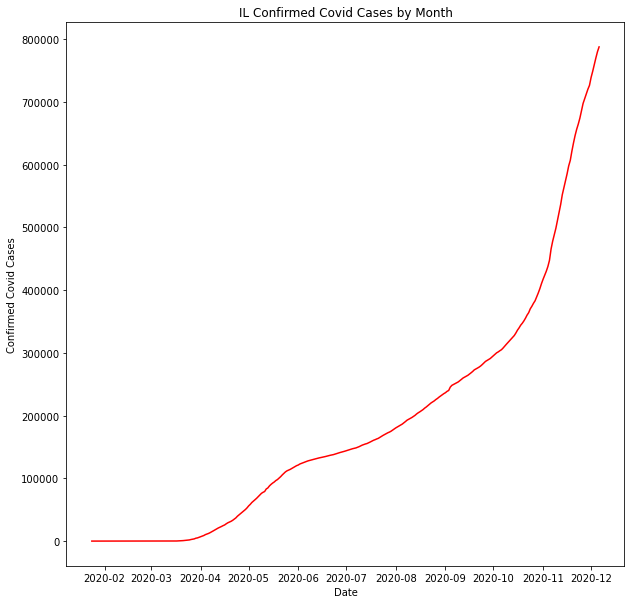

In [14]:
# Found an excellent tutorial on using datetime from normal Pandas object here:
# https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/

fig, ax = plt.subplots(figsize=(10,10))

plt.plot(covid_raw_il.index.values, covid_raw_il['confirmed_cases'], color='red')
ax.set(xlabel= "Date",
      ylabel="Confirmed Covid Cases",
      title="IL Confirmed Covid Cases by Month")
plt.show()

In [15]:
# We need to reindex back to a range index in order to use pandas .grouper() method later to groupby and aggregate by max.
covid_raw_il.reset_index(inplace=True)

# # Let's drop the month's day since we'll be joining with unemployment data above without day.
# covid_raw_il['dateString'] = covid_raw_il['dateString'].dt.strftime('%m-%Y') #this didn't work!  I found I need to use .dt
# on my last step, otherwise I will always lose dateTime .dtype.
# https://stackoverflow.com/questions/52869614/pandas-convert-datetime-format-mm-dd-yyyy-to-dd-mm-yyyy

Since the BLS data is only offered on a monthly, instead of daily cadence like the COVID data, we have to group up the COVID data into monthly metrics, identifying the maximum infection rate for that month.  We could have also just extracted the last day of the month, as the rates are cumulative; however, the logic is easier to just identify a monthly maximum using Pandas Grouper method with "M" monthly parameter.

In [16]:
# Used Grouper() method from Pandas to group by month and average values using Pandas docs for guidance here:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Grouper.html?highlight=grouper
covid_il_grouped = covid_raw_il.groupby(pd.Grouper(key='dateString', freq='M')).max()

In [17]:
covid_il_grouped.reset_index(inplace=True)

In [18]:
covid_il_grouped['dateString'] = covid_il_grouped['dateString'].dt.strftime('%m-%Y')

In [19]:
covid_il_grouped

,dateString,confirmed_cases,confirmed_cases_change,confirmed_cases_change_pct,confirmed_cases_minus_deaths,deaths,deaths_change,deaths_change_pct,total_tested,total_tested_change,total_tested_change_pct,date
0,01-2020,2,1.0,100.00,2,0,0.0,0.00,NaN,NaN,0.00,2020-01-30T00:00:00.000Z
1,02-2020,3,1.0,50.00,3,0,0.0,0.00,NaN,NaN,0.00,2020-02-29T00:00:00.000Z
2,03-2020,5994,1105.0,100.00,5895,99,27.0,200.00,35225.0,4911.0,59.46,2020-03-31T00:00:00.000Z
3,04-2020,52918,2724.0,16.45,50563,2355,142.0,42.42,269867.0,16124.0,14.65,2020-04-30T00:00:00.000Z
4,05-2020,120260,4014.0,5.93,114871,5389,191.0,6.61,898259.0,29307.0,6.61,2020-05-31T00:00:00.000Z
5,06-2020,143185,1614.0,1.33,136264,6921,116.0,2.07,1602965.0,31686.0,2.62,2020-06-30T00:00:00.000Z
6,07-2020,178837,1941.0,1.10,171342,7495,37.0,0.53,2699568.0,49782.0,2.13,2020-07-31T00:00:00.000Z
7,08-2020,235023,2356.0,1.15,226998,8025,36.0,0.45,4064161.0,56766.0,1.64,2020-08-31T00:00:00.000Z
8,09-2020,293274,5368.0,2.24,284603,8671,39.0,0.49,5624822.0,149273.0,3.59,2020-09-30T00:00:00.000Z
9,10-2020,410300,7899.0,1.96,400543,9757,67.0,0.72,7729845.0,95111.0,1.34,2020-10-31T00:00:00.000Z



Now we have to join the data between the BLS monthly unemployment rates for IL counties and the IL COVID data aggregated at a monthly level.


In [20]:
lau_covid_il = pd.merge(bls_rate_2020_il_cn, covid_il_grouped, how='left', on=['dateString', 'dateString'])

In [21]:
lau_covid_il

,series_id,year,period,value,footnote_codes,dateString,fips,confirmed_cases,confirmed_cases_change,confirmed_cases_change_pct,confirmed_cases_minus_deaths,deaths,deaths_change,deaths_change_pct,total_tested,total_tested_change,total_tested_change_pct,date
0,LAUCN170010000000003,2020,M01,3.3,NaN,01-2020,001,2,1.0,100.00,2,0,0.0,0.00,NaN,NaN,0.00,2020-01-30T00:00:00.000Z
1,LAUCN170010000000003,2020,M02,2.8,NaN,02-2020,001,3,1.0,50.00,3,0,0.0,0.00,NaN,NaN,0.00,2020-02-29T00:00:00.000Z
2,LAUCN170010000000003,2020,M03,2.5,NaN,03-2020,001,5994,1105.0,100.00,5895,99,27.0,200.00,35225.0,4911.0,59.46,2020-03-31T00:00:00.000Z
3,LAUCN170010000000003,2020,M04,12.0,NaN,04-2020,001,52918,2724.0,16.45,50563,2355,142.0,42.42,269867.0,16124.0,14.65,2020-04-30T00:00:00.000Z
4,LAUCN170010000000003,2020,M05,10.5,NaN,05-2020,001,120260,4014.0,5.93,114871,5389,191.0,6.61,898259.0,29307.0,6.61,2020-05-31T00:00:00.000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,LAUCN172030000000003,2020,M06,9.3,NaN,06-2020,203,143185,1614.0,1.33,136264,6921,116.0,2.07,1602965.0,31686.0,2.62,2020-06-30T00:00:00.000Z
1016,LAUCN172030000000003,2020,M07,7.3,NaN,07-2020,203,178837,1941.0,1.10,171342,7495,37.0,0.53,2699568.0,49782.0,2.13,2020-07-31T00:00:00.000Z
1017,LAUCN172030000000003,2020,M08,6.5,NaN,08-2020,203,235023,2356.0,1.15,226998,8025,36.0,0.45,4064161.0,56766.0,1.64,2020-08-31T00:00:00.000Z
1018,LAUCN172030000000003,2020,M09,5.6,NaN,09-2020,203,293274,5368.0,2.24,284603,8671,39.0,0.49,5624822.0,149273.0,3.59,2020-09-30T00:00:00.000Z


In [22]:
# Here we need to convert the fips column to an int so we can merge with the IL county geopandas boundaries below.
lau_covid_il['fips'] = pd.to_numeric(lau_covid_il['fips'])

### IL Geographical Boundary Data
Finally, we introduce the state and county boundary data from ESRI who makes this data freely available and allows data retrievals from their host API.  While this was by far the easiest data to retrieve and use as is, I did run into issues with some Pandas operations not working (e.g. .contains.str()) and so had to extract some data into separate Pandas series for the dashboard's conditional operations.

In [23]:
# ESRI Open data with Creative Commons license found here: 
# https://www.arcgis.com/home/item.html?id=72da6887c3fc4070b62f534eac5ea079
il_bound = gpd.read_file("https://opendata.arcgis.com/datasets/72da6887c3fc4070b62f534eac5ea079_0.geojson")

In [24]:
il_bound

,FID,AREA_,PERIMETER,NC4_,NC4_ID,FIPS_CO,STATE_CODE,TOTALPOP,NAME_LC,DISTRICT,COUNTY_NAM,STR_STATEC,SHAPE_area,SHAPE_len,GlobalID,geometry
0,1,1.314209e+10,504248.19090,2,3,97,49,519515,lake,1,LAKE,049,1.314209e+10,504248.166488,55f98094-bcc0-4607-a199-467bc5df2139,"POLYGON ((-87.80265 42.49259, -87.80256 42.491..."
1,2,1.704184e+10,522912.63363,3,5,111,56,183241,mchenry,1,MCHENRY,056,1.704263e+10,522779.162317,0ef63edc-8fe9-4d46-a5f3-e1b75495f9d1,"POLYGON ((-88.19946 42.49407, -88.19944 42.492..."
2,3,1.724584e+10,579951.49059,4,1,85,43,21821,jodaviess,2,JO DAVIESS,043,1.724584e+10,579951.512994,d568bb64-2c05-466a-817a-8504e63d6540,"POLYGON ((-90.63082 42.50789, -90.61836 42.507..."
3,4,1.574499e+10,506026.51459,5,2,177,89,48052,stephenson,2,STEPHENSON,089,1.574499e+10,506026.547630,2b46c7bf-691b-4e3f-9395-6a27984f5885,"POLYGON ((-89.74155 42.50539, -89.74155 42.505..."
4,5,1.447768e+10,501614.78373,6,4,201,101,252913,winnebago,2,WINNEBAGO,101,1.447768e+10,501614.722490,74d3257f-8e23-4bbf-91b1-b5cf2b4650c4,"POLYGON ((-89.38438 42.50033, -89.38293 42.500..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,98,9.723745e+09,422725.03361,99,98,87,44,11347,johnson,9,JOHNSON,044,9.723745e+09,422725.029759,05214a4a-18af-4938-9418-c4e1f8f6c5e0,"POLYGON ((-88.76045 37.60023, -88.75383 37.600..."
98,99,1.176391e+10,489546.21914,100,99,181,91,17619,union,9,UNION,091,1.176391e+10,489546.255506,a0451377-b2a4-43a1-a85e-92dae9179937,"POLYGON ((-89.09913 37.59795, -89.09870 37.597..."
99,100,6.758354e+09,379787.08595,101,100,127,64,14752,massac,9,MASSAC,064,6.758354e+09,379787.129540,06b40696-a54e-465c-9896-131d0c6b9ab1,"POLYGON ((-88.71063 37.33699, -88.70445 37.332..."
100,101,5.670785e+09,459129.16659,102,102,153,77,7523,pulaski,9,PULASKI,077,5.670784e+09,459129.227046,0be0e256-307f-4057-922a-ece257de8a7d,"POLYGON ((-89.21666 37.33514, -89.20959 37.334..."



Let's have a quick look at the IL boundaries plot with matplotlib, to make sure everything looks as we expect.  Later we'll introduce the COVID and BLS unemployment data with this geodataframe to create a choropleth heatmap of unemployment rates by month.  But next, let's join the IL boundaries data with our already merged BLS and COVID data to create our final, main dataset.


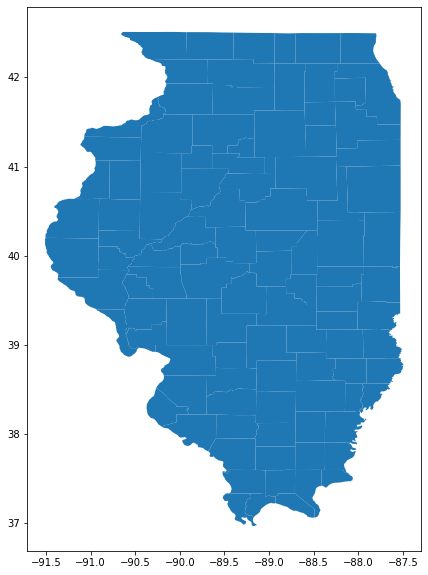

In [25]:
fig, ax = plt.subplots(figsize=(10,10))
il_bound.plot(ax=ax)
plt.show()

In [26]:
il_covid_map = pd.merge(lau_covid_il, il_bound, how='left', left_on='fips', right_on='FIPS_CO')

In [27]:
il_covid_map

,series_id,year,period,value,footnote_codes,dateString,fips,confirmed_cases,confirmed_cases_change,confirmed_cases_change_pct,...,STATE_CODE,TOTALPOP,NAME_LC,DISTRICT,COUNTY_NAM,STR_STATEC,SHAPE_area,SHAPE_len,GlobalID,geometry
0,LAUCN170010000000003,2020,M01,3.3,NaN,01-2020,1,2,1.0,100.00,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
1,LAUCN170010000000003,2020,M02,2.8,NaN,02-2020,1,3,1.0,50.00,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
2,LAUCN170010000000003,2020,M03,2.5,NaN,03-2020,1,5994,1105.0,100.00,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
3,LAUCN170010000000003,2020,M04,12.0,NaN,04-2020,1,52918,2724.0,16.45,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
4,LAUCN170010000000003,2020,M05,10.5,NaN,05-2020,1,120260,4014.0,5.93,...,1,66090,adams,6,ADAMS,001,2.429405e+10,632871.258309,11f4cc80-d397-44fa-a5e1-e39af4c01b7b,"POLYGON ((-91.44645 40.19953, -91.44645 40.199..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,LAUCN172030000000003,2020,M06,9.3,NaN,06-2020,203,143185,1614.0,1.33,...,102,32653,woodford,4,WOODFORD,102,1.513613e+10,570047.672789,3a2aa4be-ace4-4289-8062-93ea11563737,"POLYGON ((-88.93142 40.92773, -88.93147 40.916..."
1016,LAUCN172030000000003,2020,M07,7.3,NaN,07-2020,203,178837,1941.0,1.10,...,102,32653,woodford,4,WOODFORD,102,1.513613e+10,570047.672789,3a2aa4be-ace4-4289-8062-93ea11563737,"POLYGON ((-88.93142 40.92773, -88.93147 40.916..."
1017,LAUCN172030000000003,2020,M08,6.5,NaN,08-2020,203,235023,2356.0,1.15,...,102,32653,woodford,4,WOODFORD,102,1.513613e+10,570047.672789,3a2aa4be-ace4-4289-8062-93ea11563737,"POLYGON ((-88.93142 40.92773, -88.93147 40.916..."
1018,LAUCN172030000000003,2020,M09,5.6,NaN,09-2020,203,293274,5368.0,2.24,...,102,32653,woodford,4,WOODFORD,102,1.513613e+10,570047.672789,3a2aa4be-ace4-4289-8062-93ea11563737,"POLYGON ((-88.93142 40.92773, -88.93147 40.916..."


In [28]:
# I was having issues with plotting my new merged dataframe, and found on this StackOverflow that when I performed the merge
# above between a pandas dataframe and a geopandas dataframe, it takes the type of a regular Pandas dataframe.  
# Solution provided by Dharman here: https://stackoverflow.com/questions/63974040/line2d-object-has-no-property-column
il_covid_map = GeoDataFrame(il_covid_map)

In [29]:
type(il_covid_map)

geopandas.geodataframe.GeoDataFrame

Now with the data in its final form, let extract just one month of data and plot it into a matplotlib based on the 'value' column which will use all of the unemployment rates for the month of September 2020 to create a heatmap/choropleth by county.  It will also create a legend showing the range of unemployment rates.


In [30]:
sept = il_covid_map[il_covid_map['dateString']=='09-2020']

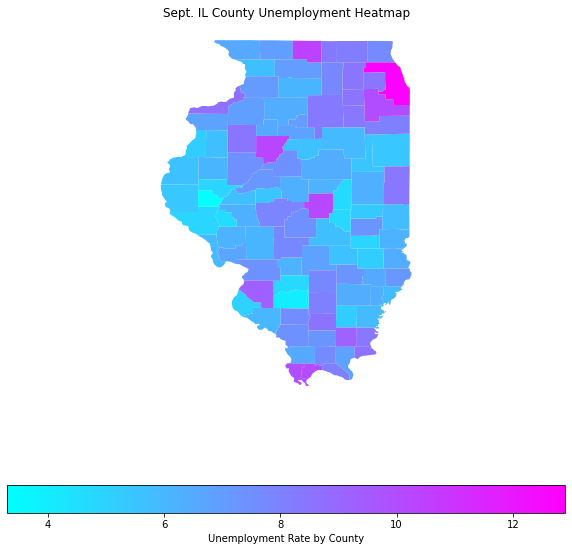

In [31]:
# Generate the choropleth map using gdf plot function on the Confirmed 
# I liked the styling that Kishan Nagaraj used for his Covid-19 world map, but his code did not seem well formed when compared
# to what we learned in this class.  I instead reused his color choices, but used Dr. Naiman's code approach below.
columnfig = sept.plot(column='value',cmap='cool',figsize=(10,10),
                              legend = True, legend_kwds={'label': "Unemployment Rate by County",'orientation': "horizontal"})
# remove axis ticks
plt.axis('off')
plt.title("Sept. IL County Unemployment Heatmap")
plt.show()

Now here is where we build out our final dashboard using the data that we've looked at above.  We'll create an option for the end-user to select from a series of buttons with the associated months.  Since we only have BLS unemployment data up to October (BLS has yet to extract unemployment numbers for November in our current dataset, even though it is December), we'll need to include some Try/Except logic to notify the user that not all data is available when they select a month button without data.

In [32]:
# Resetting our COVID dataset to index by time for easier time series analysis.
covid_raw_il['dateString'] = pd.to_datetime(covid_raw_il['dateString'], format='%m-%Y')
covid_raw_il.set_index('dateString', inplace=True)

In [51]:
# ToggleButtons ipywidget code sample from ipywidget docs here:  
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html#ToggleButtons
month_toggle = ipywidgets.ToggleButtons(
    options=['01-2020', '02-2020', '03-2020', '04-2020','05-2020','06-2020','07-2020','08-2020','09-2020','10-2020','11-2020',
            '12-2020'],
    description='Period:',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    # tooltips=['Description of slow', 'Description of regular', 'Description of fast'],
    # icons=['check'] * 3
)

month_name = {
    '01-2020':'Janurary',
    '02-2020':'February',
    '03-2020':'March',
    '04-2020':'April',
    '05-2020':'May',
    '06-2020':'June',
    '07-2020':'July',
    '08-2020':'August',
    '09-2020':'September',
    '10-2020':'October',
    '11-2020':'November',
    '12-2020':'December'
}

def county_plot(date):
    clear_output()
    year = date['new'][3:7]
    month = date['new'][:2]
    index_string = str(covid_raw_il.index.values)
    periods = pd.Series(il_covid_map['dateString'])
          
    # Setup plt subplot criteria
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=False, sharey=False, figsize = (15,10))
    # Title formating from matplotlib docs here:  https://matplotlib.org/tutorials/text/text_intro.html 
    fig.suptitle('IL ' + month_name.get(date['new']) +' Unemployment by Confirmed COVID-19 Cases', fontsize=18, fontweight='bold')
    fig.autofmt_xdate()
    
    # plotting the line plot of confirmed Covid-19 cases at time period selected
    try:
        if (str(year + '-' + month)) not in index_string:
            raise ValueError('IL COVID-19 data does not exist for that time period.  Please choose another period.')
            pass
        else:
            covid_raw_il.index.values, covid_raw_il['confirmed_cases'].plot(ax=ax1, color='blue')
            ax1.set(xlabel= "Date",
                  ylabel="Confirmed Covid Cases",
                  title="IL Confirmed Covid Cases by Month")
    #Here we'll add in a dynamic line plot that only shows the time range from Janurary to the month selected.
    #This adds visualization context to b
            ax1.set_xlim([datetime.date(2020, 1, 1), datetime.date(int(date['new'][3:7]), int(date['new'][:2]) + 1, 1)])

    except ValueError as e:
        print(e)
        
        
    try:
        # plotting the IL county heatmap
        # Found syntax for .contains() Pandas method from a post by Alex Huong Tran on StackOverflow here:
        # https://stackoverflow.com/questions/56558907/str-contains-in-pandas-with-if-statement-python 
        if not periods.str.contains(date['new']).any():
            print('Sorry, there currently is not unemployment data for the ' + date['new'] + \
                  ' period. Please choose a different period.')
            plt.show()
            display(month_toggle)
    
        else:
            il_covid_map[il_covid_map.dateString == date['new']].plot(ax=ax2, column='value',
                                                                      cmap='cool',
                                                                      legend=True,
                                                                      legend_kwds=
                                                                      {'label': "Unemployment Rate (%)"}).axis('off')
            ax2.set(xlabel= "Date",
                  title="IL County Unemployment Rates")

            plt.show()
            display(month_toggle)
        
    except Exception as ex:
        print(ex)


month_toggle.observe(county_plot, 'value')


## Dashboard of IL Monthly Confirmed COVID Cases and Unemployment Rates

***Note:*** If you have not already, in order for the dashboard buttons to show, you must run the Jupyter Notebook Kernel for the widgets to render.  To do so, click on "Kernel>Restart & Run All" in the menu bar of this Jupyter Notebook.

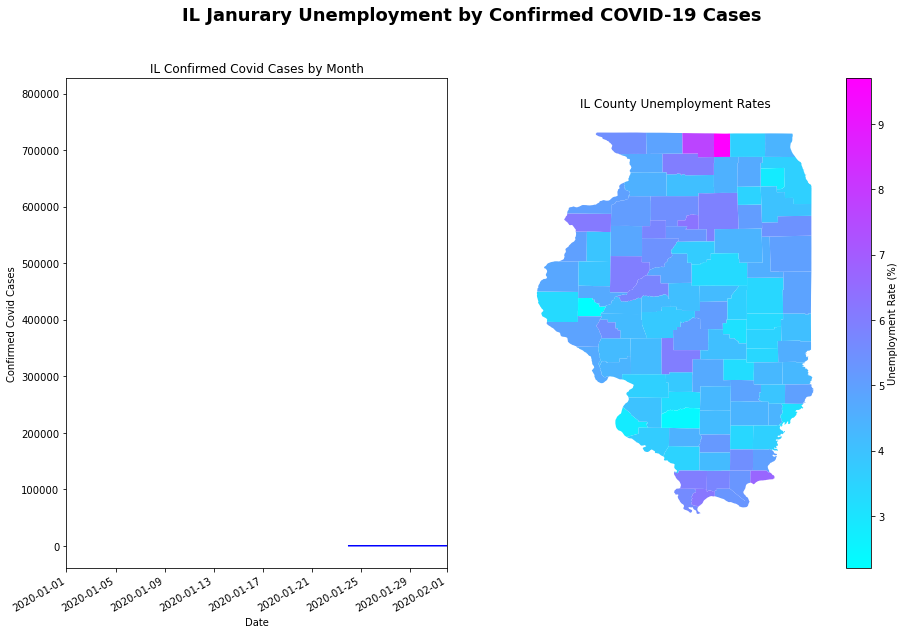

ToggleButtons(button_style='info', description='Period:', options=('01-2020', '02-2020', '03-2020', '04-2020',…

In [52]:
county_plot({'new':'01-2020'})

### Conclusion

This dashboard can be used by anyone curious to quickly and visually see how the rise in Illinois COVID-19 cases impact the unemployment rates across the state and counties of IL.  The power of visually consuming this information is more useful than simple tables or even statistical analysis when presenting to the general public. Further analysis can be added to allow more statistical depth based on the needs of the consumer; however, we start here with simple interactions and can iterate into more complex topics as needed.